In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import pickle

## Model Performance on the Test Set

In [2]:
with open('../models/xgb_model_w_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all, xgb_model_4 = pickle.load(f)

/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:43:08] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:43:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


In [3]:
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

In [4]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.7735528979671706

## Distribution of Predicted Probability and Decile Chart

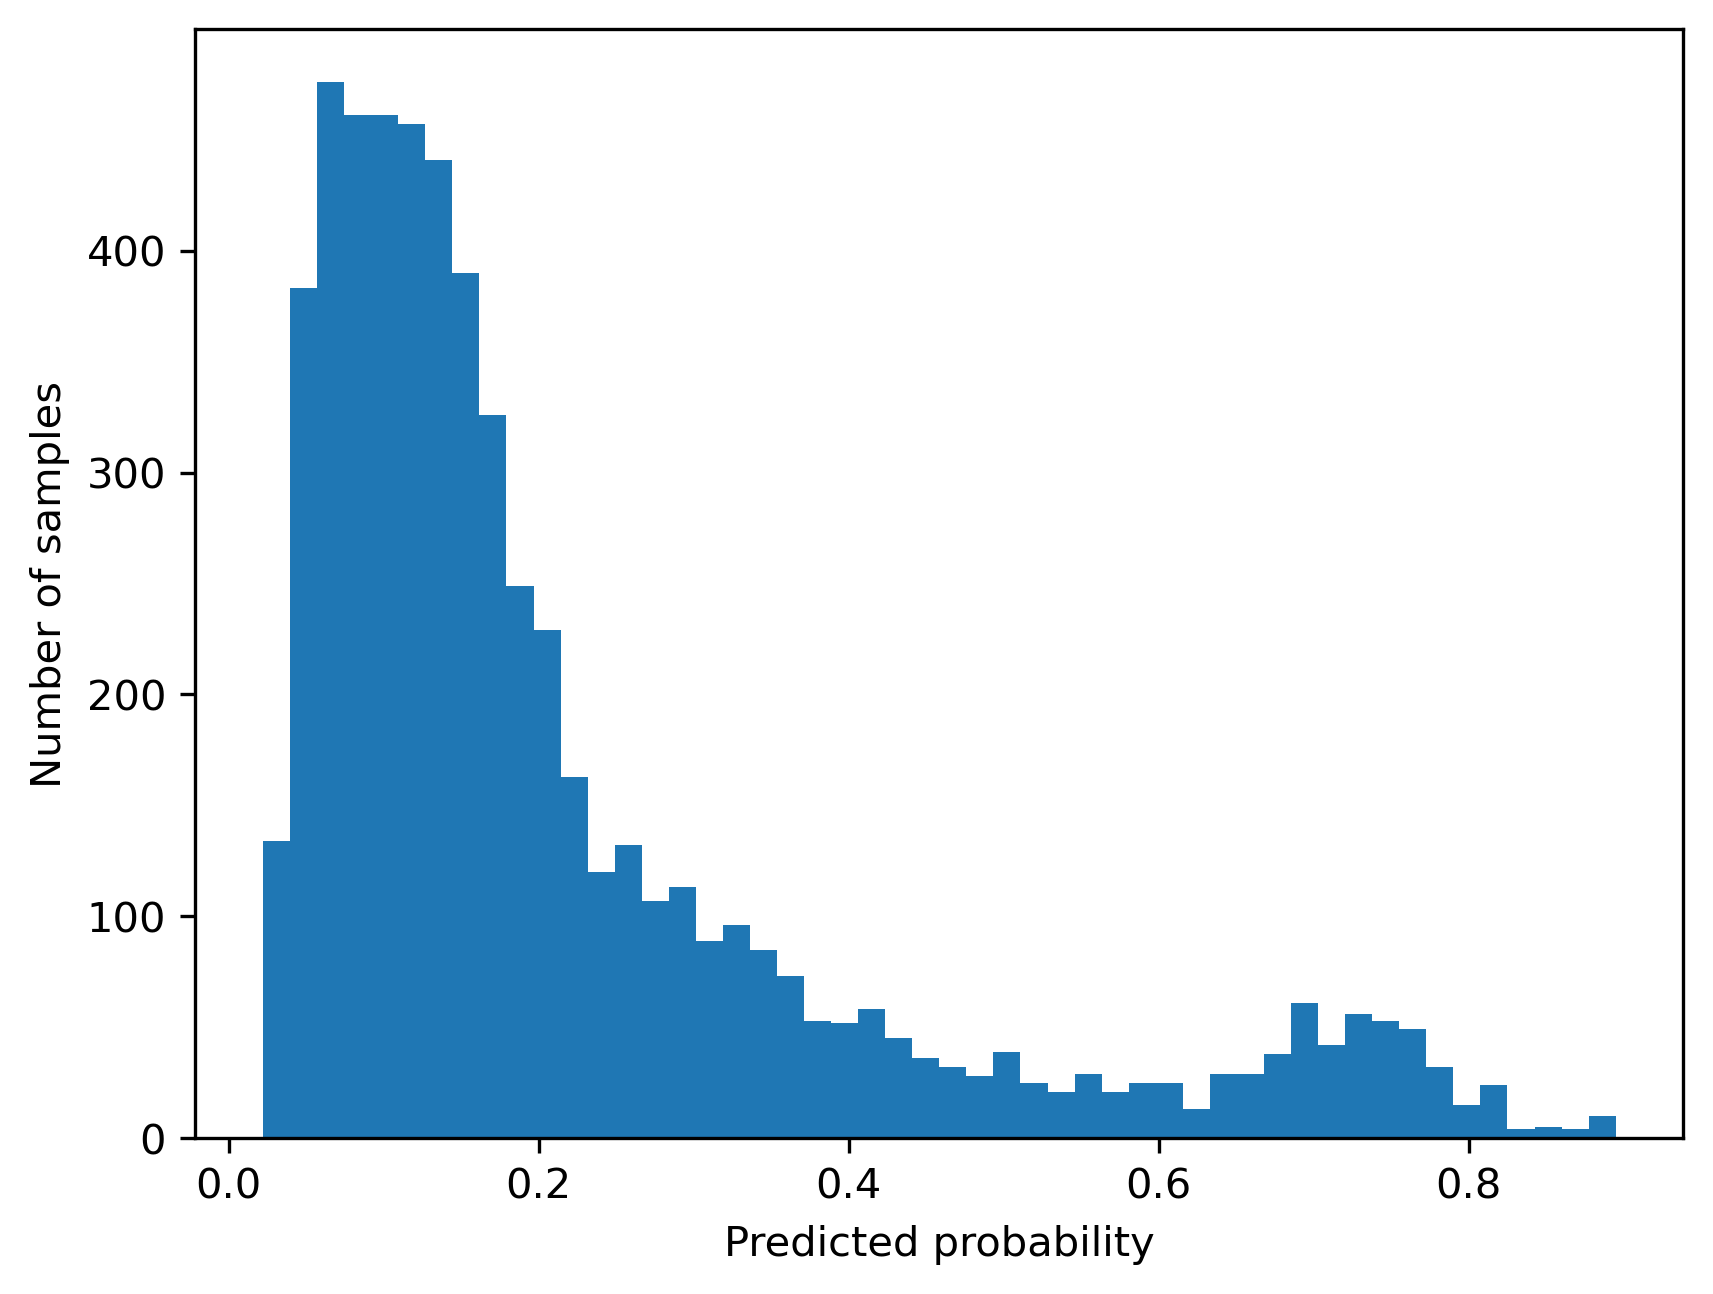

In [15]:
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples');

The histogram of predicted probabilities for the test set shows that most predictions are clustered in the range `[0, 0.2]`. In other words, most borrowers have between a 0 and 20% chance of default, according to the model. However, a small cluster of higher-risk borrowers is centred near `0.7`.

In [18]:
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba, q=10, retbins=True)
decile_bin_edges

array([0.02213463, 0.06000734, 0.08155108, 0.10424594, 0.12708404,
       0.15019046, 0.18111563, 0.23032923, 0.32210371, 0.52585585,
       0.89491451])

In [20]:
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                            'Prediction decile':deciles,
                            'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.526, 0.895]",0
1,0.621311,"(0.526, 0.895]",0
2,0.049883,"(0.0211, 0.06]",0
3,0.890924,"(0.526, 0.895]",1
4,0.272326,"(0.23, 0.322]",0


In [22]:
test_set_gr = test_set_df.groupby('Prediction decile')
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})
gr_df

/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_55515/3636182326.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_set_gr = test_set_df.groupby('Prediction decile')


Outcome          
                    count      mean
Prediction decile                  
(0.0211, 0.06]        594  0.045455
(0.06, 0.0816]        594  0.070707
(0.0816, 0.104]       594  0.099327
(0.104, 0.127]        593  0.112985
(0.127, 0.15]         594  0.116162
(0.15, 0.181]         594  0.171717
(0.181, 0.23]         593  0.195616
(0.23, 0.322]         594  0.282828
(0.322, 0.526]        594  0.392256
(0.526, 0.895]        594  0.676768

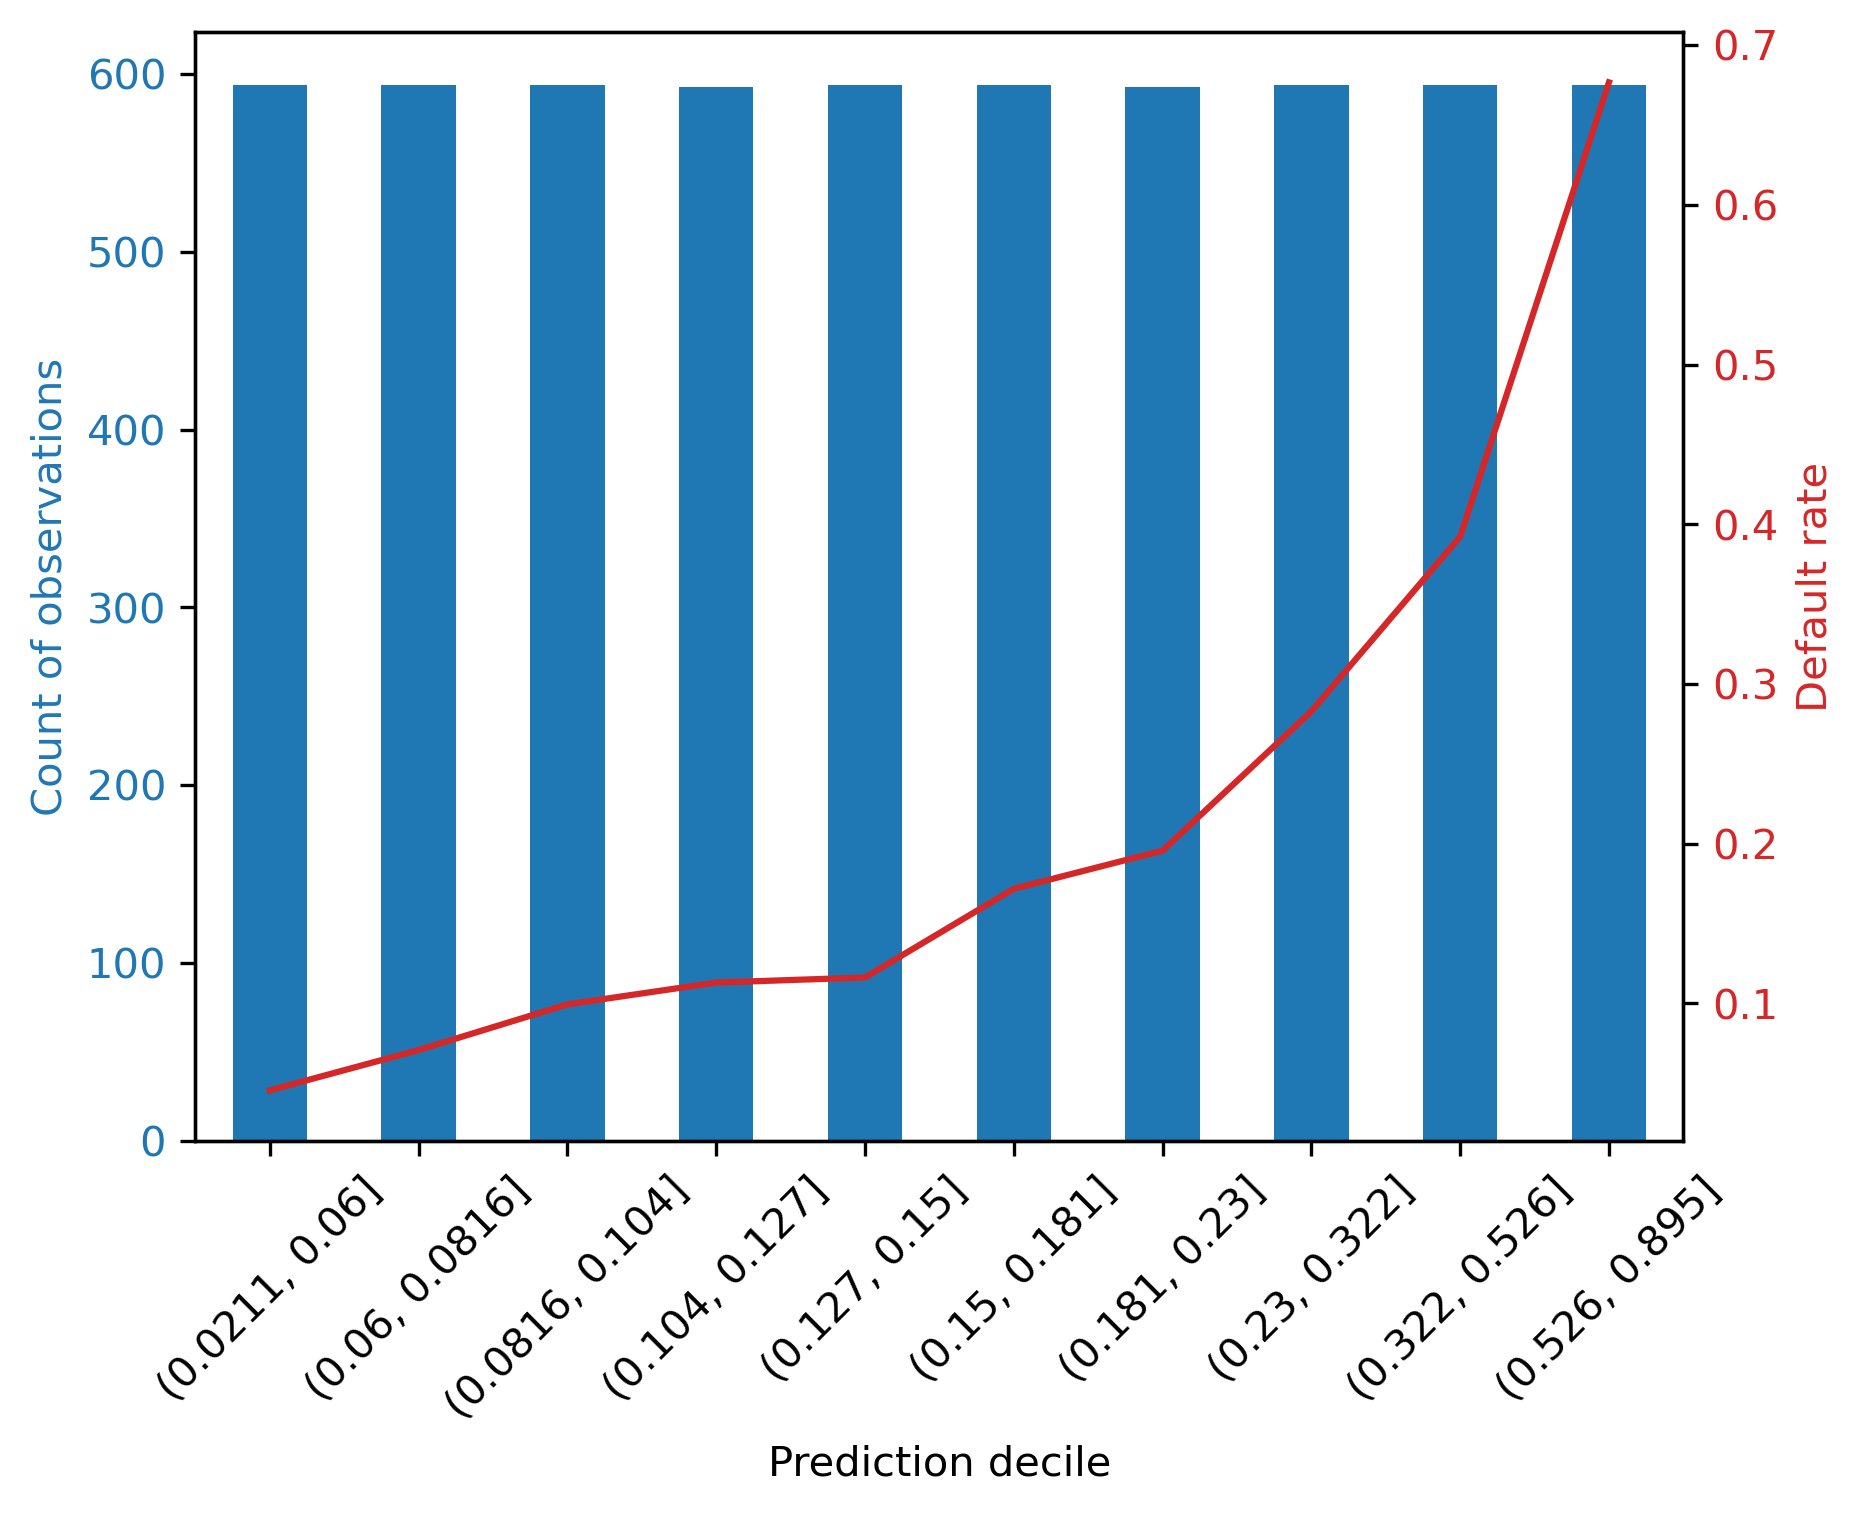

In [28]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

Default risk increases with each decile. The riskiest 10% of borrowers have a default rate close to **70%**, while the least risky borrowers have a default rate below **10%**.

## Equal-Interval Chart

In [31]:
equal_intervals, equal_interval_bin_edges = pd.cut(x=test_set_pred_proba, bins=5, retbins=True)
equal_interval_bin_edges

array([0.02126185, 0.1966906 , 0.37124658, 0.54580256, 0.72035853,
       0.89491451])

In [33]:
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1]

array([0.17542876, 0.17455598, 0.17455598, 0.17455598, 0.17455598])

In [35]:
test_set_bins_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                                 'Prediction bin':equal_intervals,
                                 'Outcome':y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction bin,Outcome
0,0.544556,"(0.371, 0.546]",0
1,0.621311,"(0.546, 0.72]",0
2,0.049883,"(0.0213, 0.197]",0
3,0.890924,"(0.72, 0.895]",1
4,0.272326,"(0.197, 0.371]",0


In [37]:
test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')
gr_eq_df = test_set_equal_gr.agg({'Outcome':['count', 'mean']})
gr_eq_df

/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_55515/2042368696.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')


Outcome          
                  count      mean
Prediction bin                   
(0.0213, 0.197]    3778  0.108788
(0.197, 0.371]     1207  0.257664
(0.371, 0.546]      389  0.465296
(0.546, 0.72]       312  0.608974
(0.72, 0.895]       252  0.761905

In [39]:
p = gr_eq_df[('Outcome', 'mean')].values
n = gr_eq_df[('Outcome', 'count')].values
std_err = np.sqrt(p * (1-p) / n)
std_err

array([0.00506582, 0.01258848, 0.02528987, 0.02762643, 0.02683029])

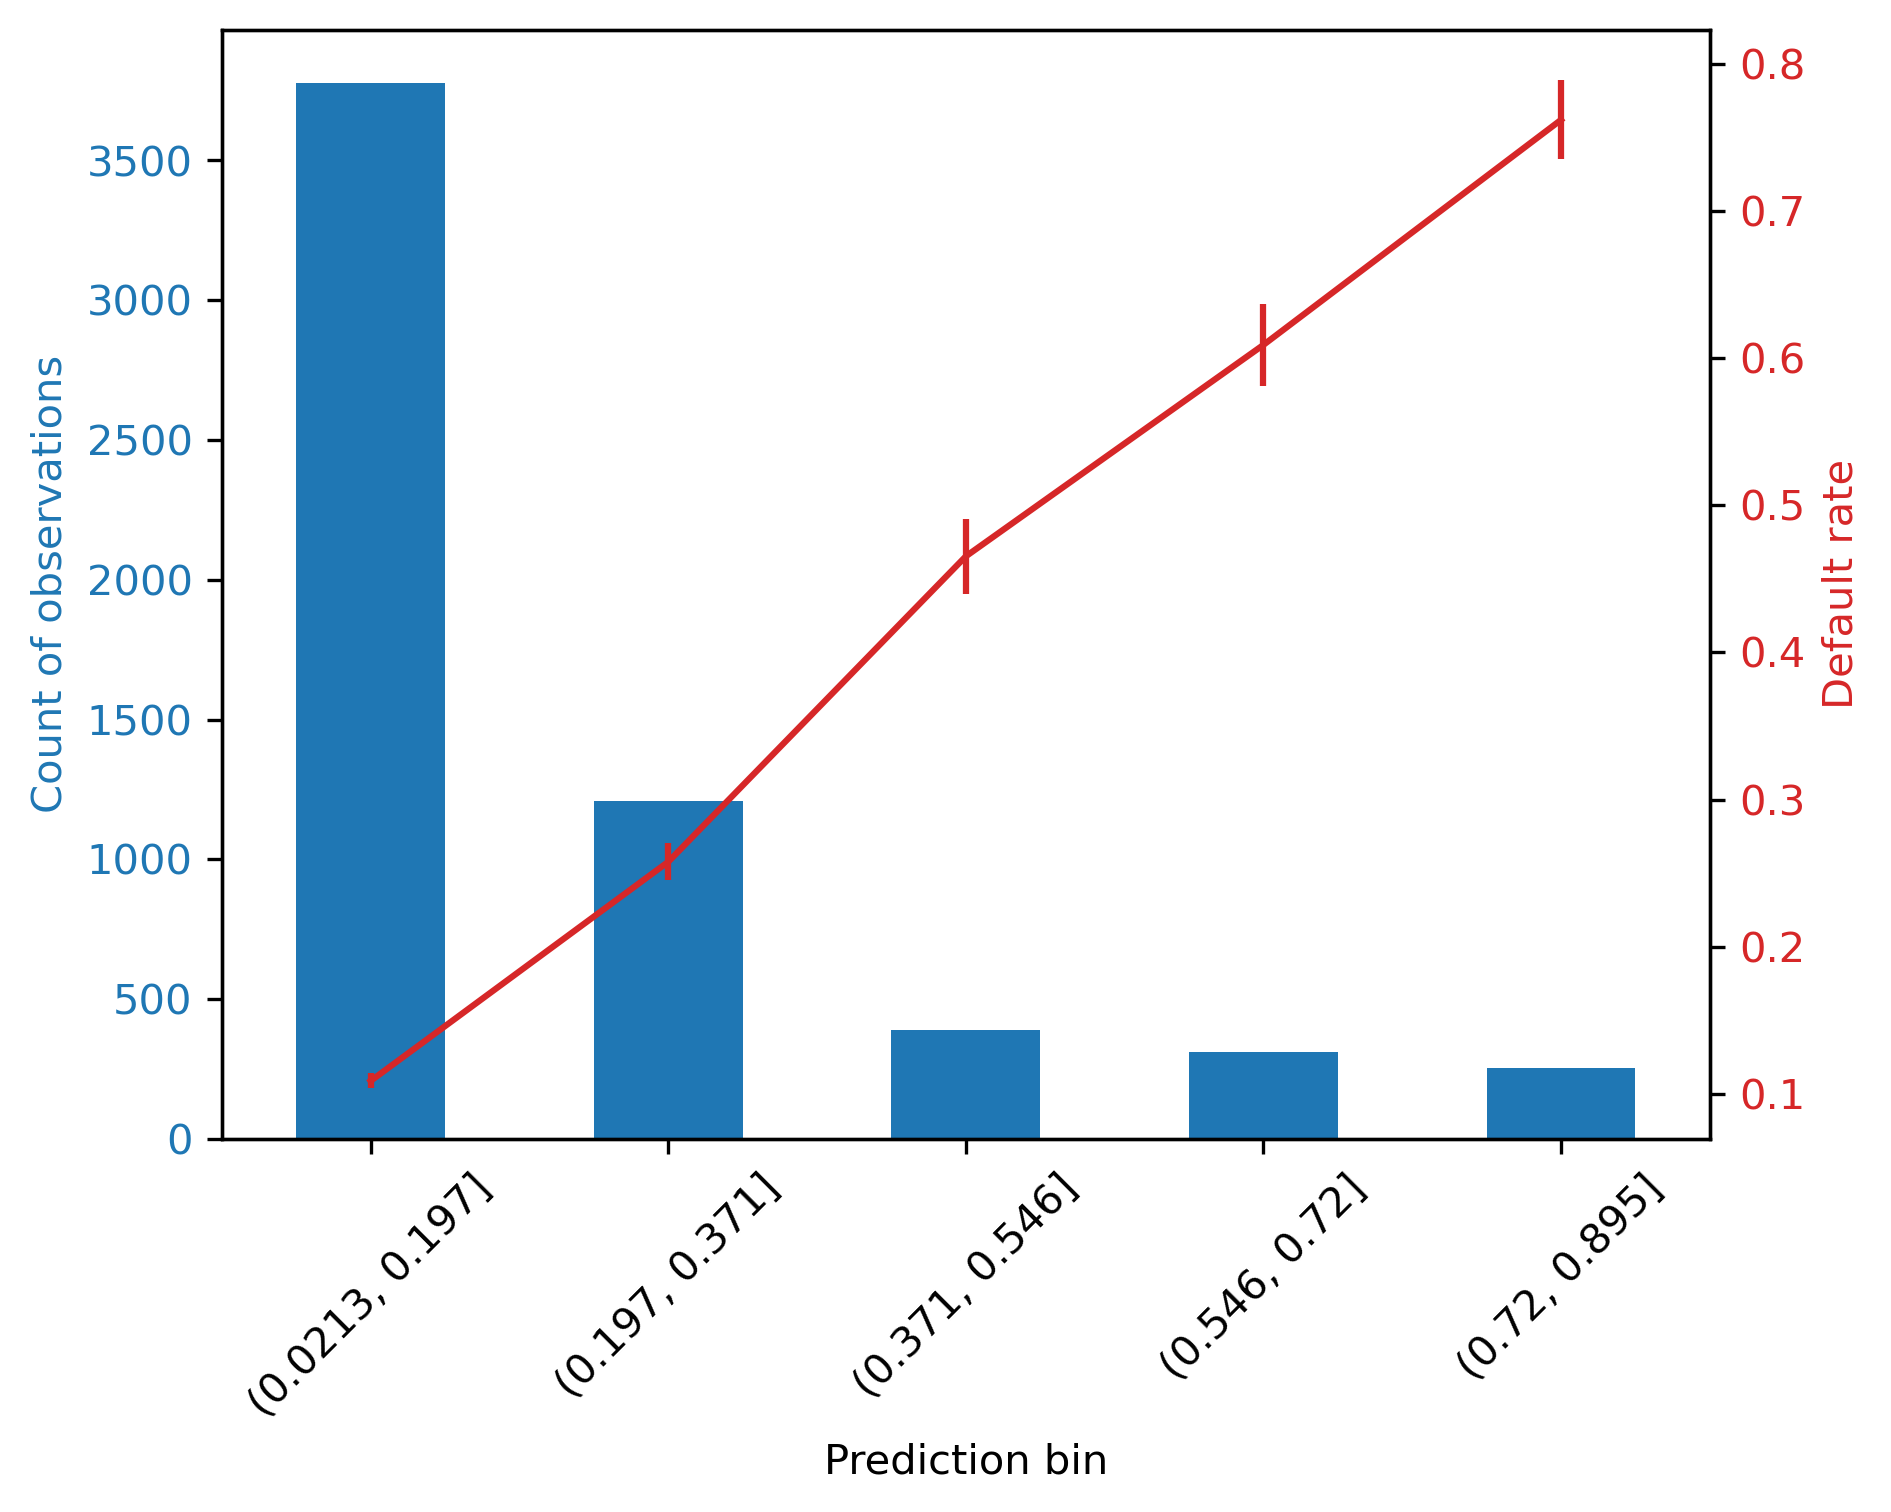

In [41]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2,
                                   yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2);

The number of samples differs among the bins, unlike the quantile approach. While there are relatively few samples in the higher score bins, leading to a more significant standard error, the error bars on the plot of default rate are still small compared to the overall trend of an increasing default rate from lower to higher score bins, so that we can be confident in this trend.

In [44]:
cal_df = test_set_gr.agg({'Outcome':['count', 'mean'],
                          'Predicted probability':'mean'})
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0211, 0.06]        594  0.045455              0.046931
(0.06, 0.0816]        594  0.070707              0.070745
(0.0816, 0.104]       594  0.099327              0.093163
(0.104, 0.127]        593  0.112985              0.115823
(0.127, 0.15]         594  0.116162              0.138656
(0.15, 0.181]         594  0.171717              0.165012
(0.181, 0.23]         593  0.195616              0.203106
(0.23, 0.322]         594  0.282828              0.273172
(0.322, 0.526]        594  0.392256              0.400159
(0.526, 0.895]        594  0.676768              0.693437

In [46]:
y_test_all.shape

(5938,)

In [48]:
F = cal_df[('Outcome', 'count')].values/y_test_all.shape[0]
F

array([0.10003368, 0.10003368, 0.10003368, 0.09986527, 0.10003368,
       0.10003368, 0.09986527, 0.10003368, 0.10003368, 0.10003368])

In [50]:
ECE = np.sum(
    F
    * np.abs(
             cal_df[('Outcome', 'mean')]
             - cal_df[('Predicted probability', 'mean')]))
ECE

0.008144500702067469

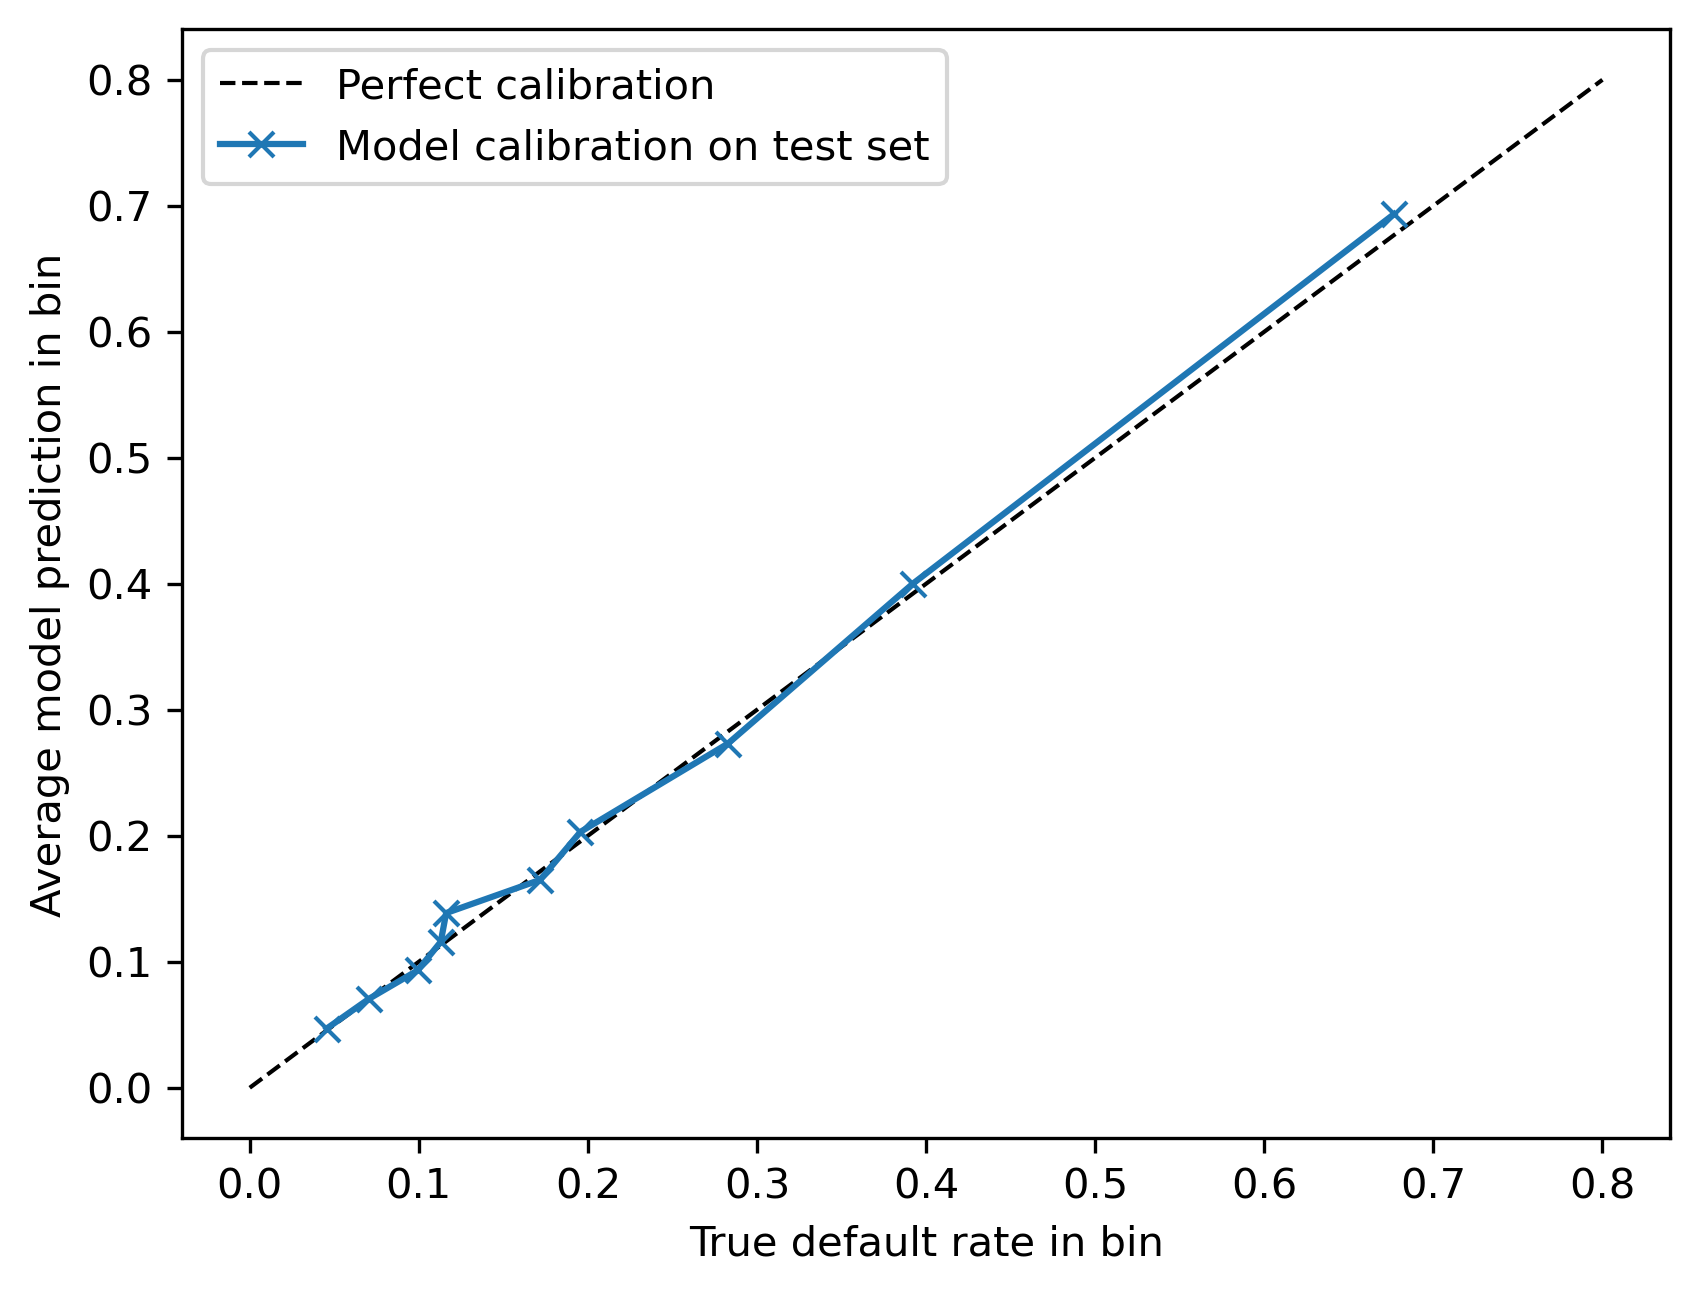

In [52]:
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1,
        label='Perfect calibration')
ax.plot(cal_df[('Outcome', 'mean')],
        cal_df[('Predicted probability', 'mean')],
        marker='x',
        label='Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend();

Model-predicted probabilities are very close to the true default rates, so the model appears well-calibrated.

## Financial Analysis

For credit accounts at a high risk of default, the client is designing a new program to provide individualized counselling for the account holder, to encourage them to pay their bill on time or to provide alternative payment options if that is not possible. Credit counselling is performed by trained customer service representatives who work in a call center. The cost per counseling session is NT$7,500, and the expected success rate of a session is 70%, meaning that, on average, 70% of the recipients of phone calls offering to counsel will pay their bill on time or make alternative arrangements that are acceptable to the creditor.

The potential benefits of successful counselling are that the amount of an account's monthly bill will be realized as savings if it was going to default but instead didn't, as a result of the counselling. Currently, the monthly bills for defaulted accounts are reported as losses.

After the preceding conversation with the client, we have the materials we need for a financial analysis. The client wants us to help them decide which members to contact and offer credit counselling. If we can help them narrow down the list of people who will be contacted for counselling, we can help save them money by avoiding unnecessary and expensive contacts.

The clients' limited resources for counseling will be more appropriately spent on accounts at higher risk of default. This should create more significant savings due to prevented defaults. Additionally, the client lets us know that our analysis can help them request a budget for the counselling program if we can give them an idea of how many counselling sessions it would be worthwhile to offer.

As we proceed to the financial analysis, we see that the decision that the model will help the client make, on an account-by-account basis, is a yes/no decision: **whether to offer counseling to the holder of a given account**. Therefore, our analysis should focus on finding an appropriate threshold of predicted probability by which we may divide our accounts into two groups: **higher-risk accounts that will receive counselling and lower-risk ones that won't**.

The connection between model output and the client's business decisions comes down to selecting a threshold for the predicted probabilities. Therefore, we will characterize the expected costs of the counselling program in terms of the costs of offering individual counselling sessions and the expected savings in terms of prevented defaults at a range of thresholds.

In [72]:
thresholds = np.linspace(0, 1, 101)
cost_per_counseling = 7500
effectiveness = 0.70

n_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)
counter = 0
for threshold in thresholds:
    pos_pred = test_set_pred_proba > threshold
    n_pos_pred[counter] = sum(pos_pred)
    total_cost[counter] \
        = n_pos_pred[counter] * cost_per_counseling
    
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    total_savings[counter] = np.sum(
        true_pos.astype(int)
        * X_test_all[:,5]
        * effectiveness
        )
    counter += 1

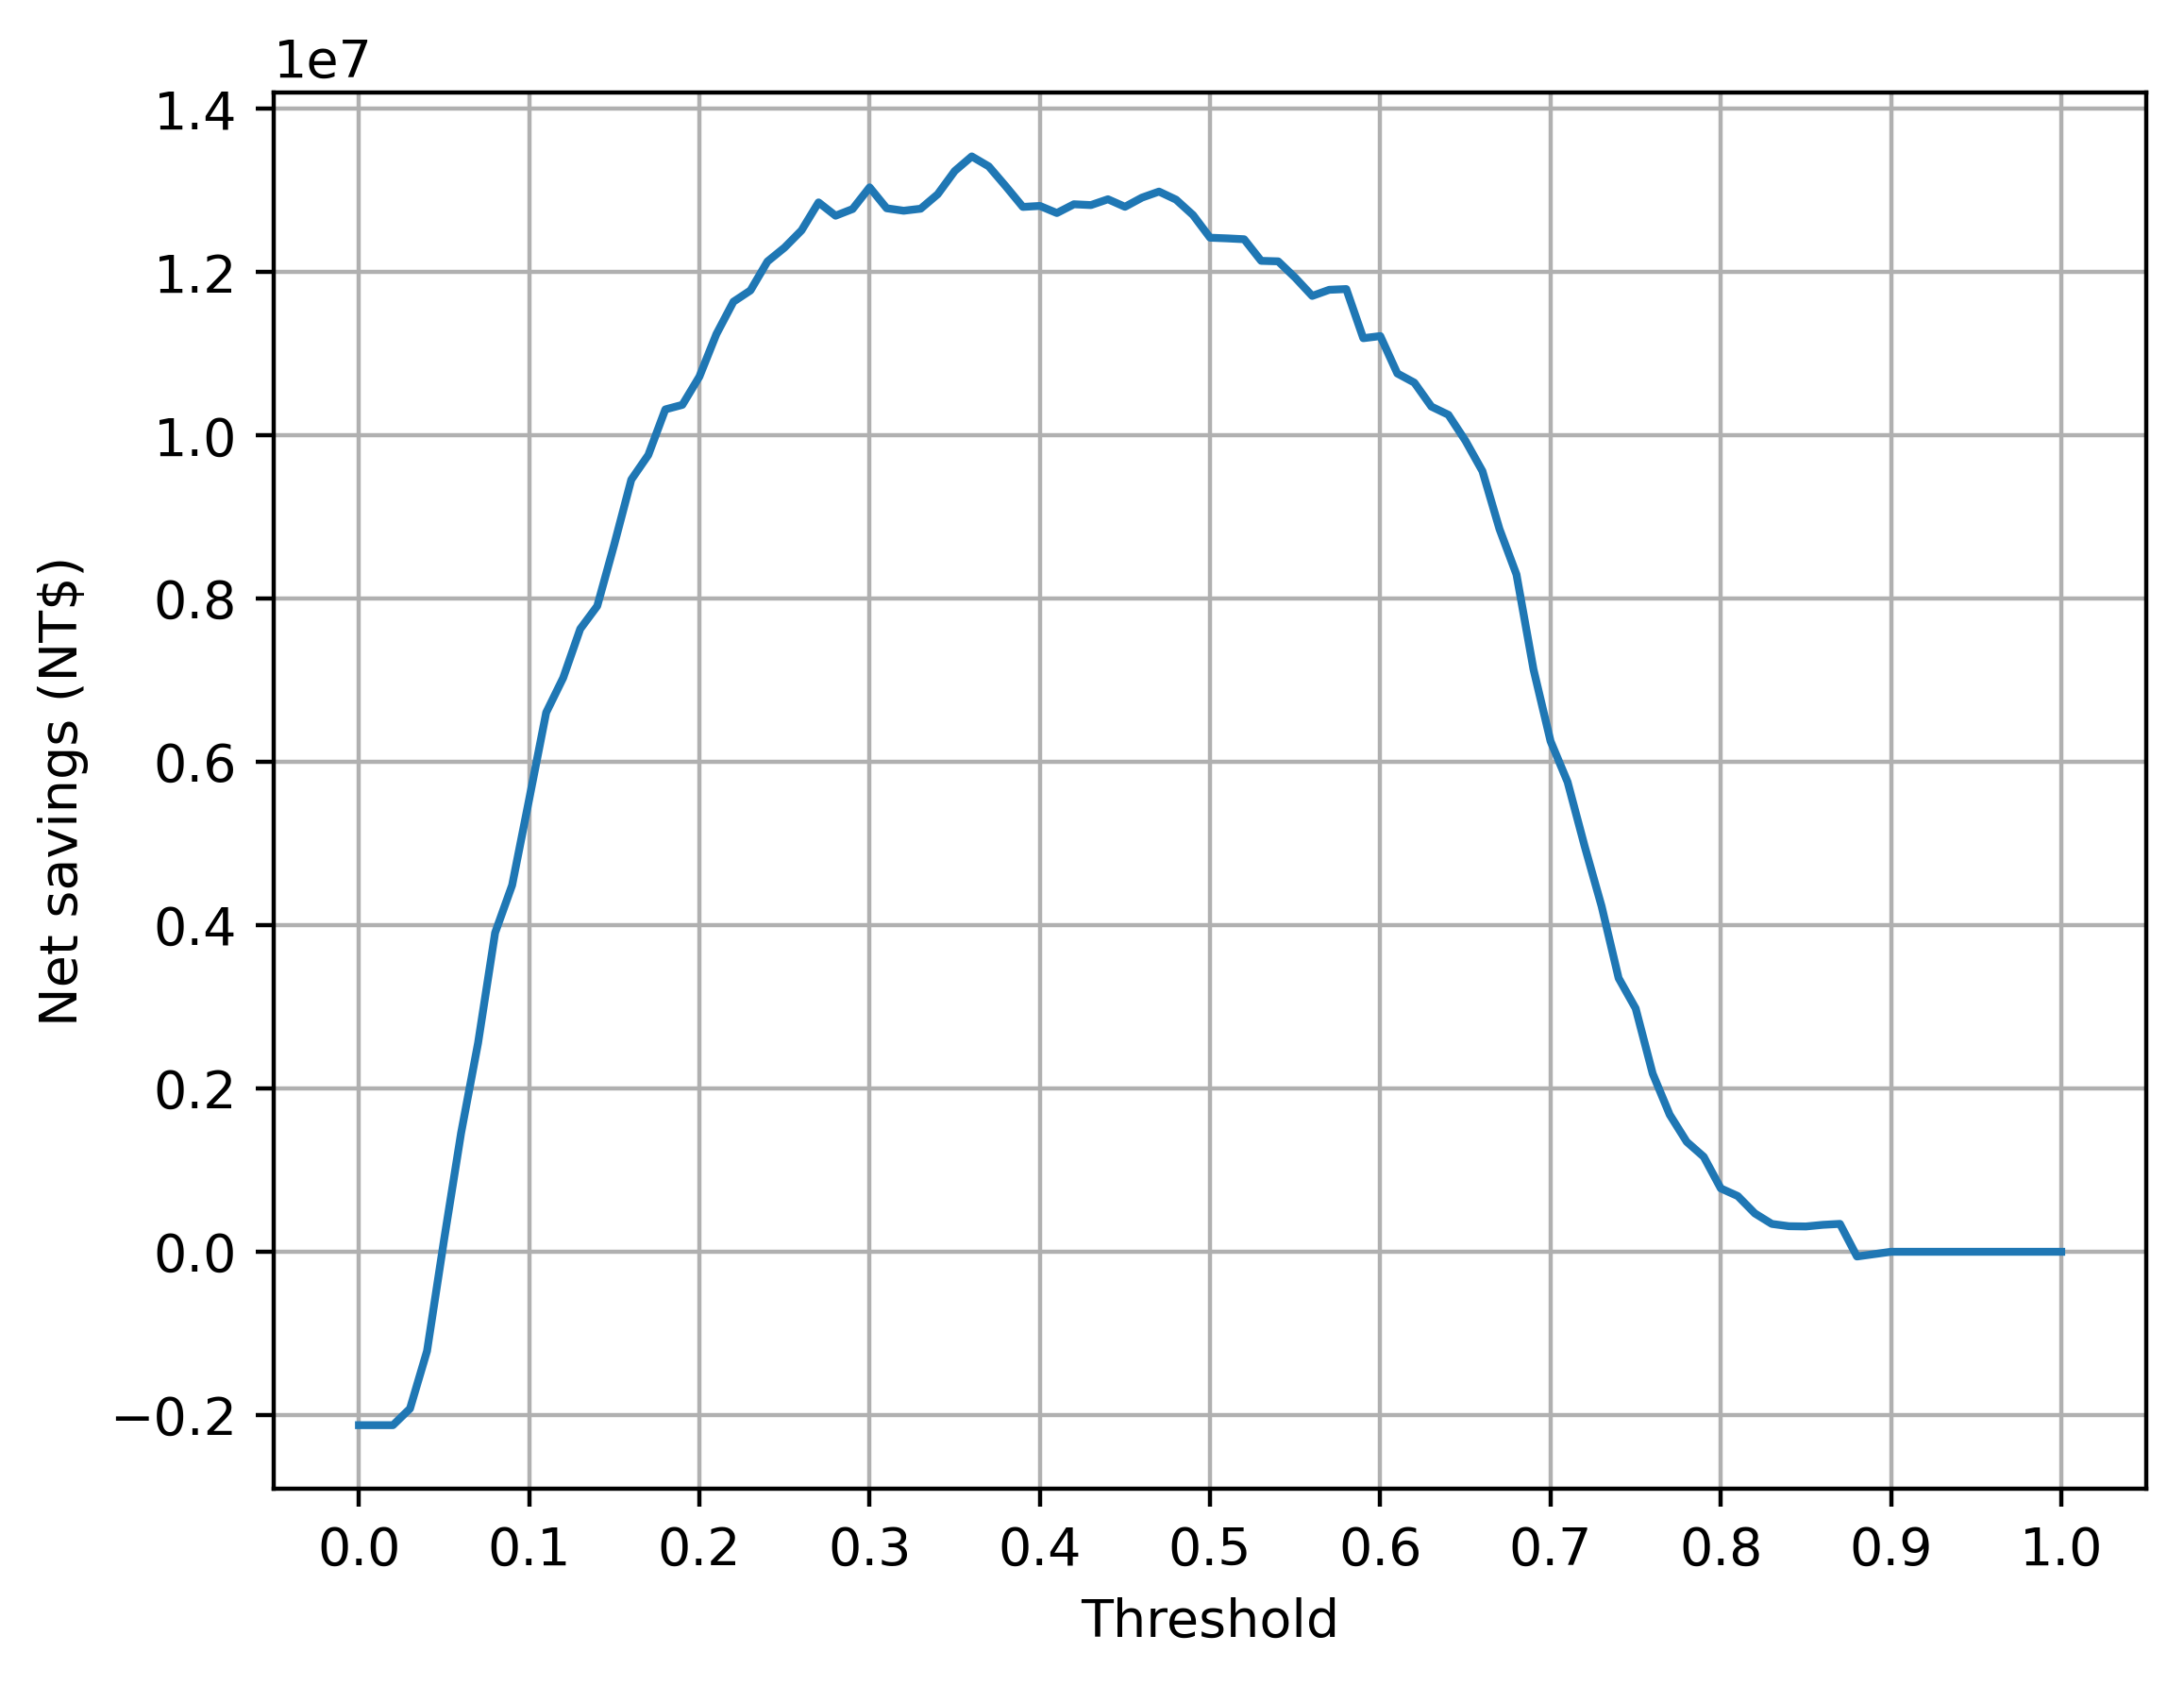

In [74]:
net_savings = total_savings - total_cost

mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [78]:
max_savings_ix = np.argmax(net_savings)
thresholds[max_savings_ix]

0.36

In [80]:
net_savings[max_savings_ix]

13415710.0

The plot indicates that the choice of threshold is essential. While it will be possible to create net savings at many different threshold values, the highest net savings will be generated by setting the threshold somewhere in the range of about 0.25 to 0.5.

We see that the most significant net savings occur at a threshold of 0.36. The net savings realized at this threshold is over NT$13 million for this testing dataset of accounts.

In [84]:
cost_of_defaults = np.sum(y_test_all * X_test_all[:,5])
cost_of_defaults

60587763.0

In [86]:
net_savings[max_savings_ix]/cost_of_defaults

0.2214260658542551

In [88]:
net_savings[max_savings_ix]/len(y_test_all)

2259.2977433479286

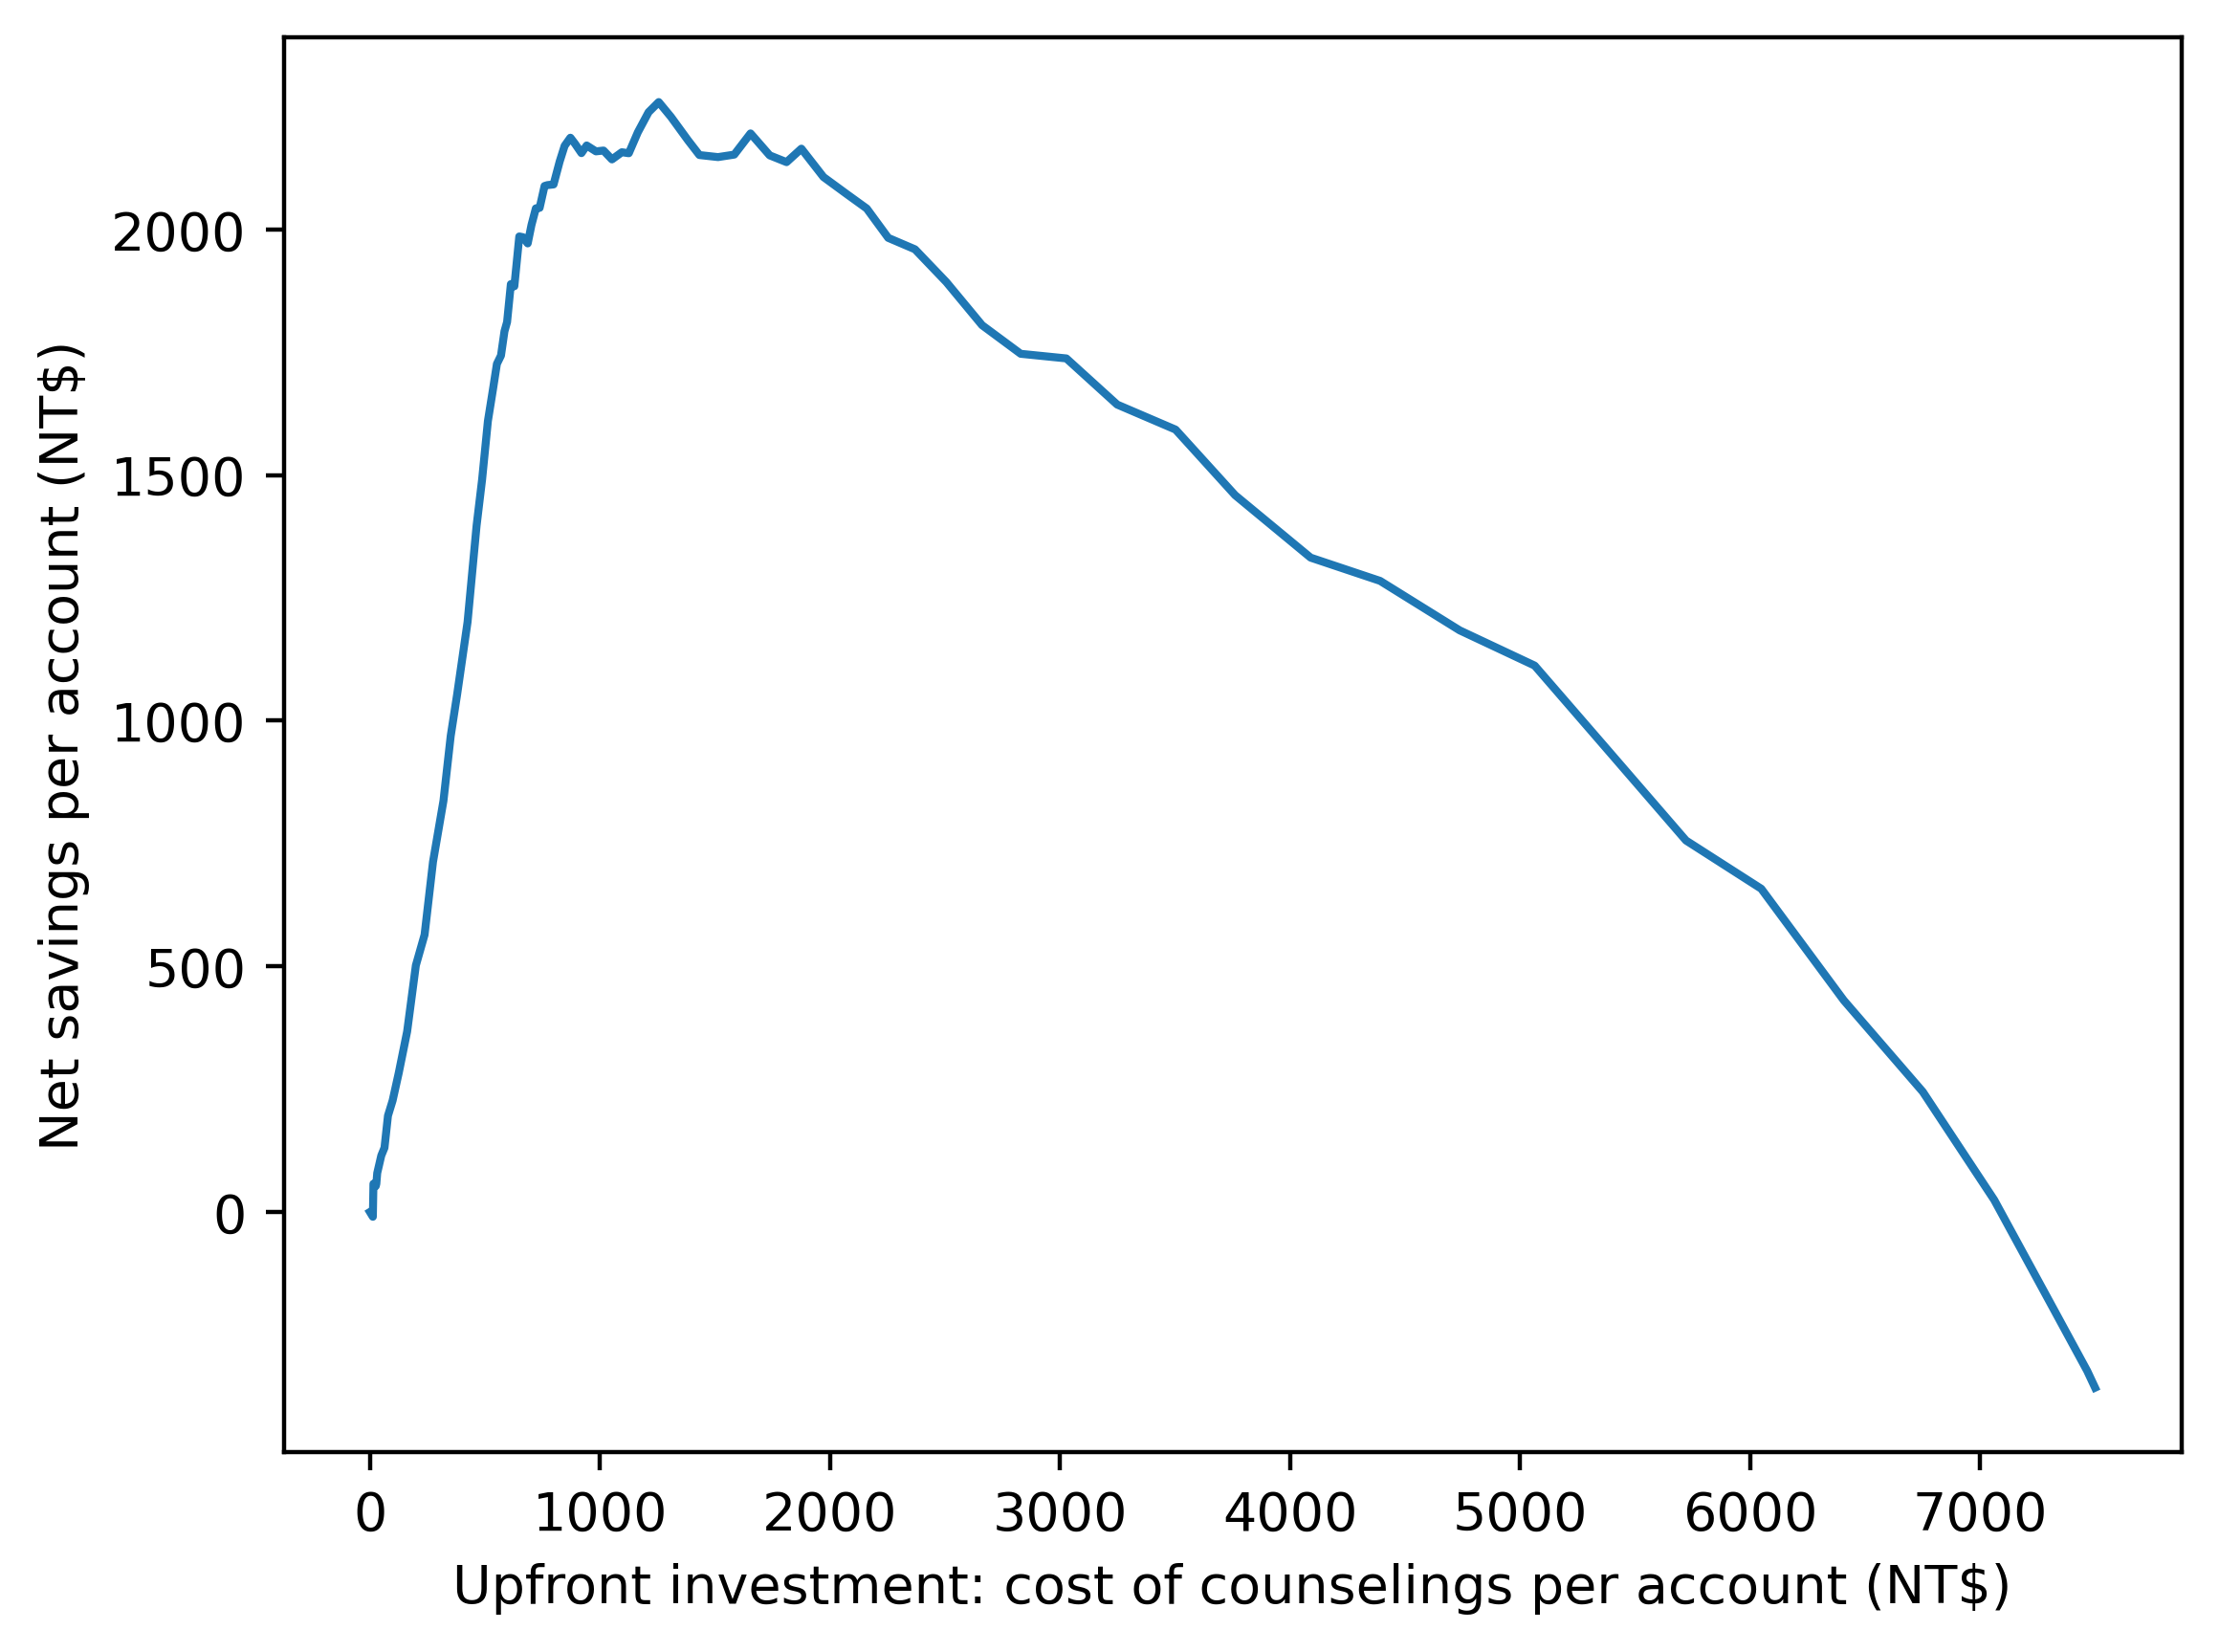

In [96]:
plt.plot(total_cost/len(y_test_all),
         net_savings/len(y_test_all))
plt.xlabel('Upfront investment: cost of counselings per account (NT$)')
plt.ylabel('Net savings per account (NT$)');

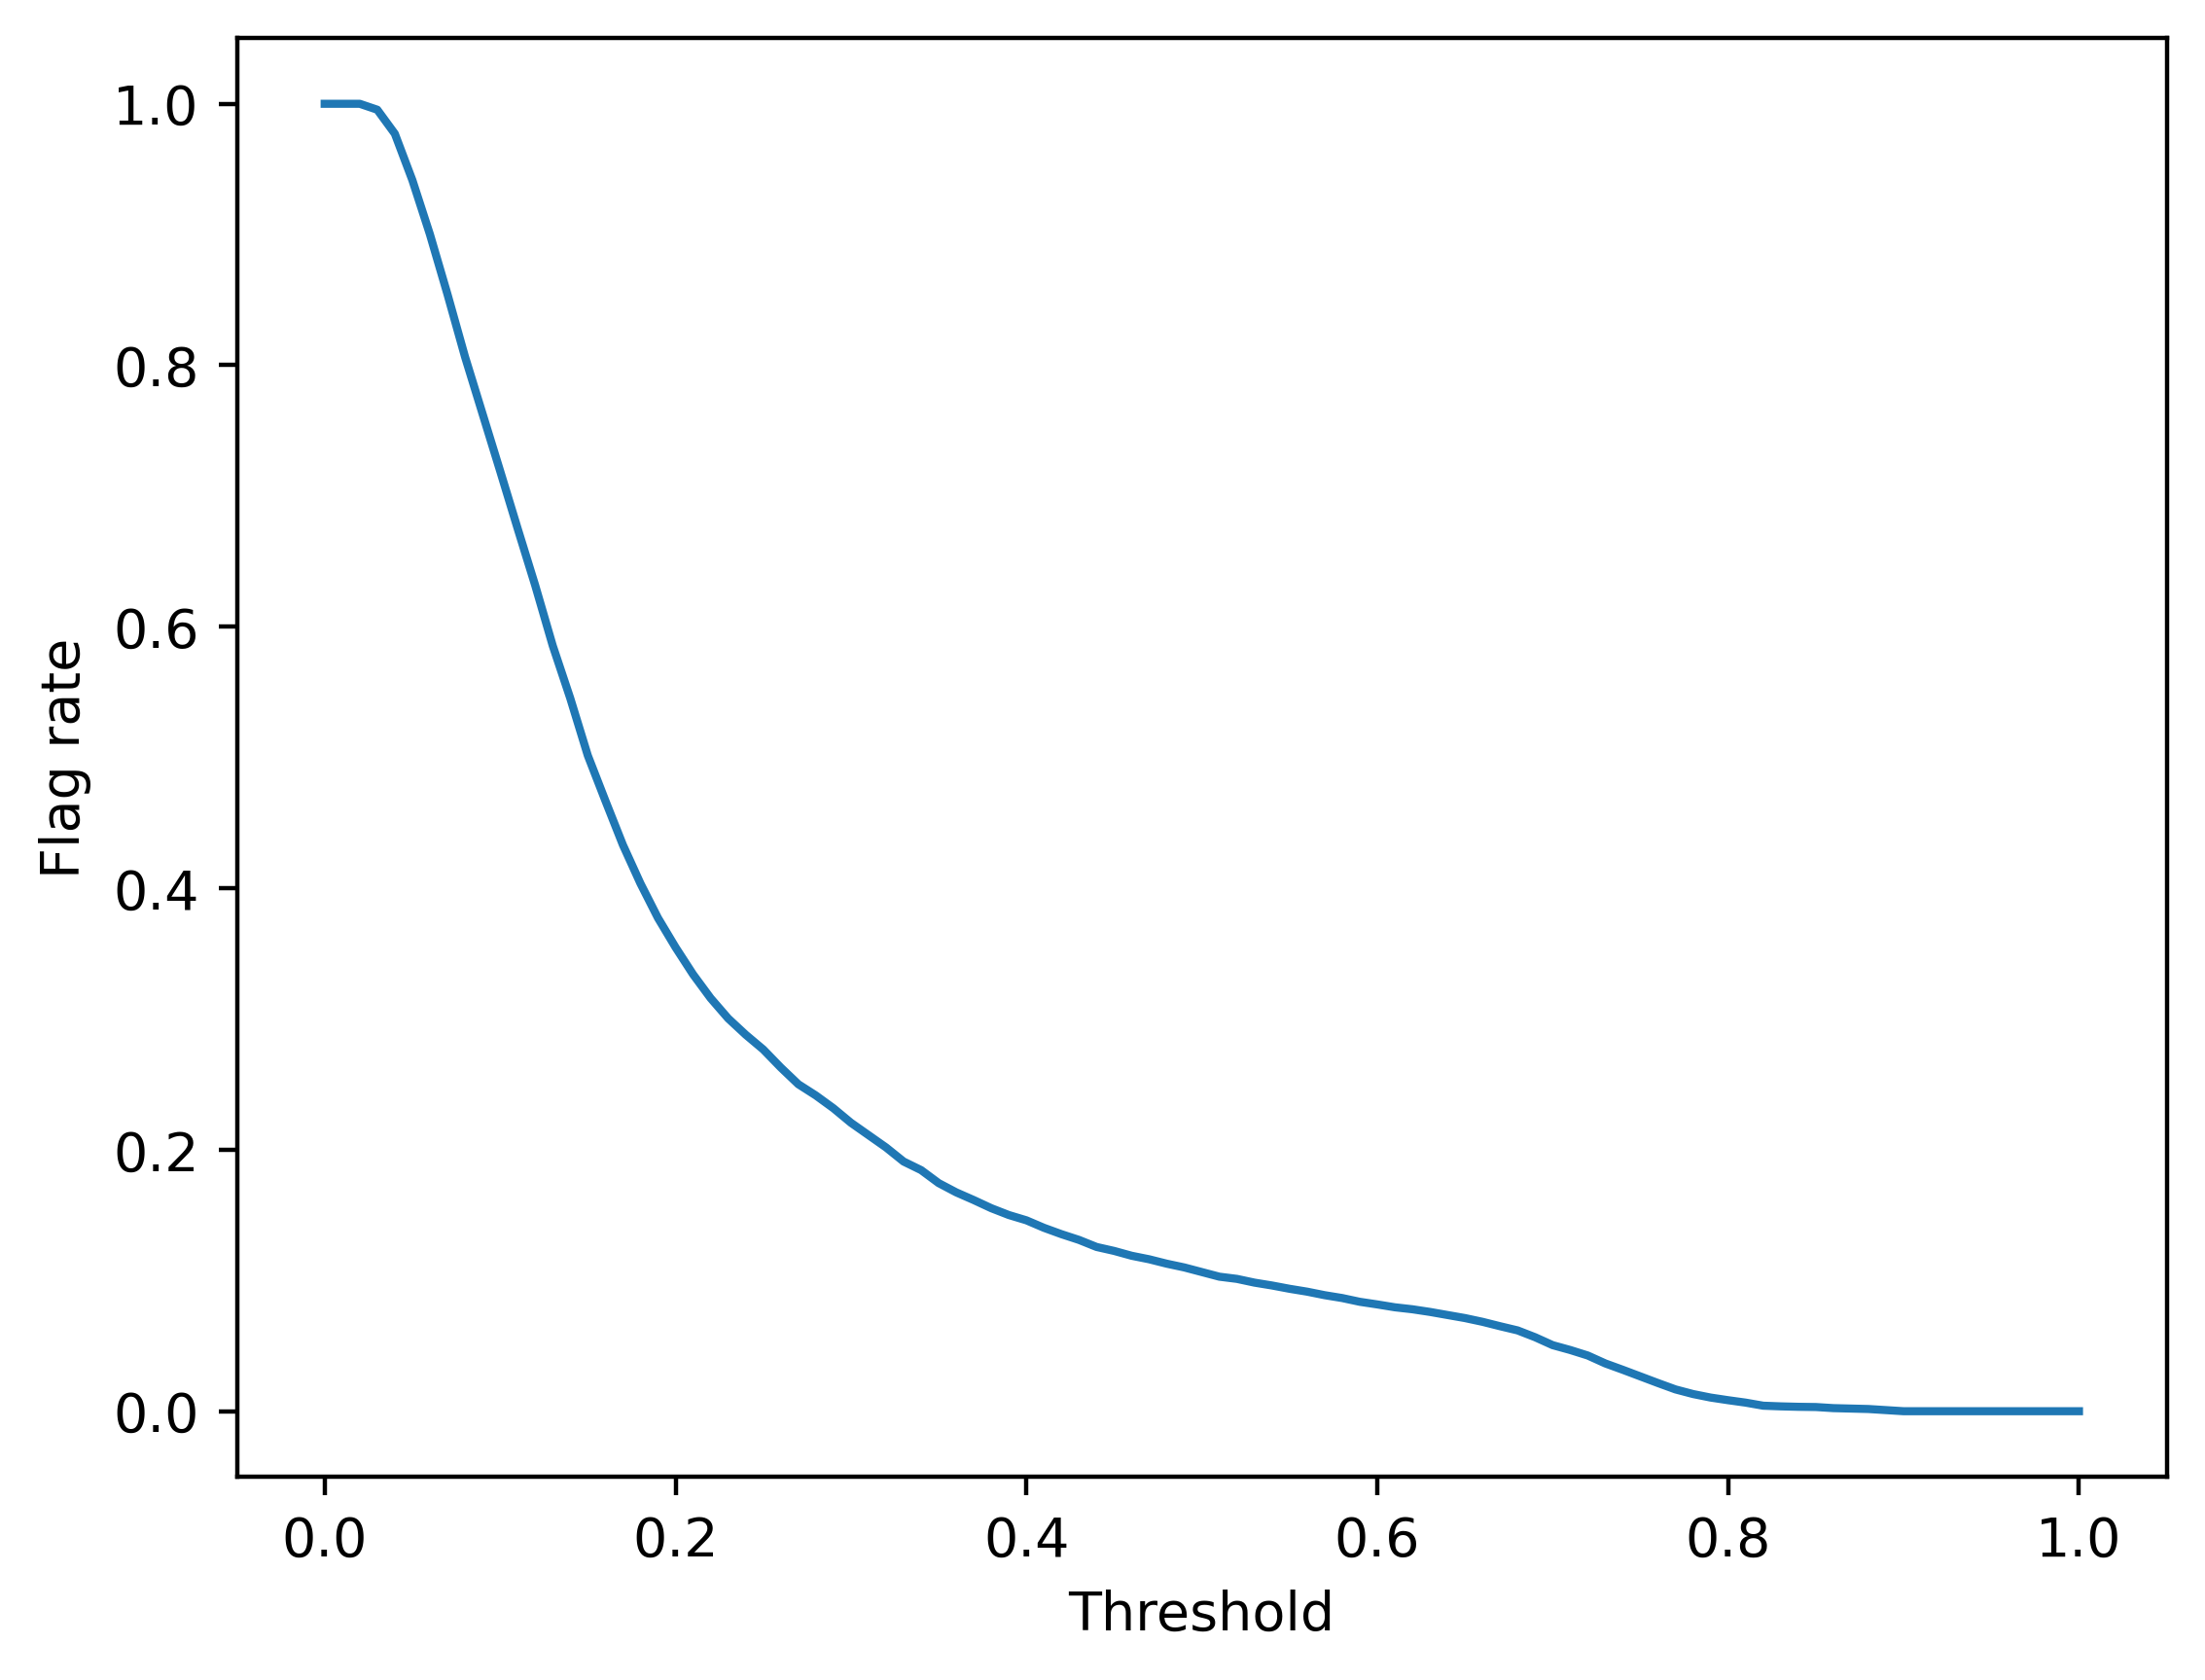

In [98]:
plt.plot(thresholds, n_pos_pred/len(y_test_all))
plt.ylabel('Flag rate')
plt.xlabel('Threshold');

/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_55515/472131428.py:2: RuntimeWarning: invalid value encountered in divide
  np.divide(n_true_pos, n_pos_pred))


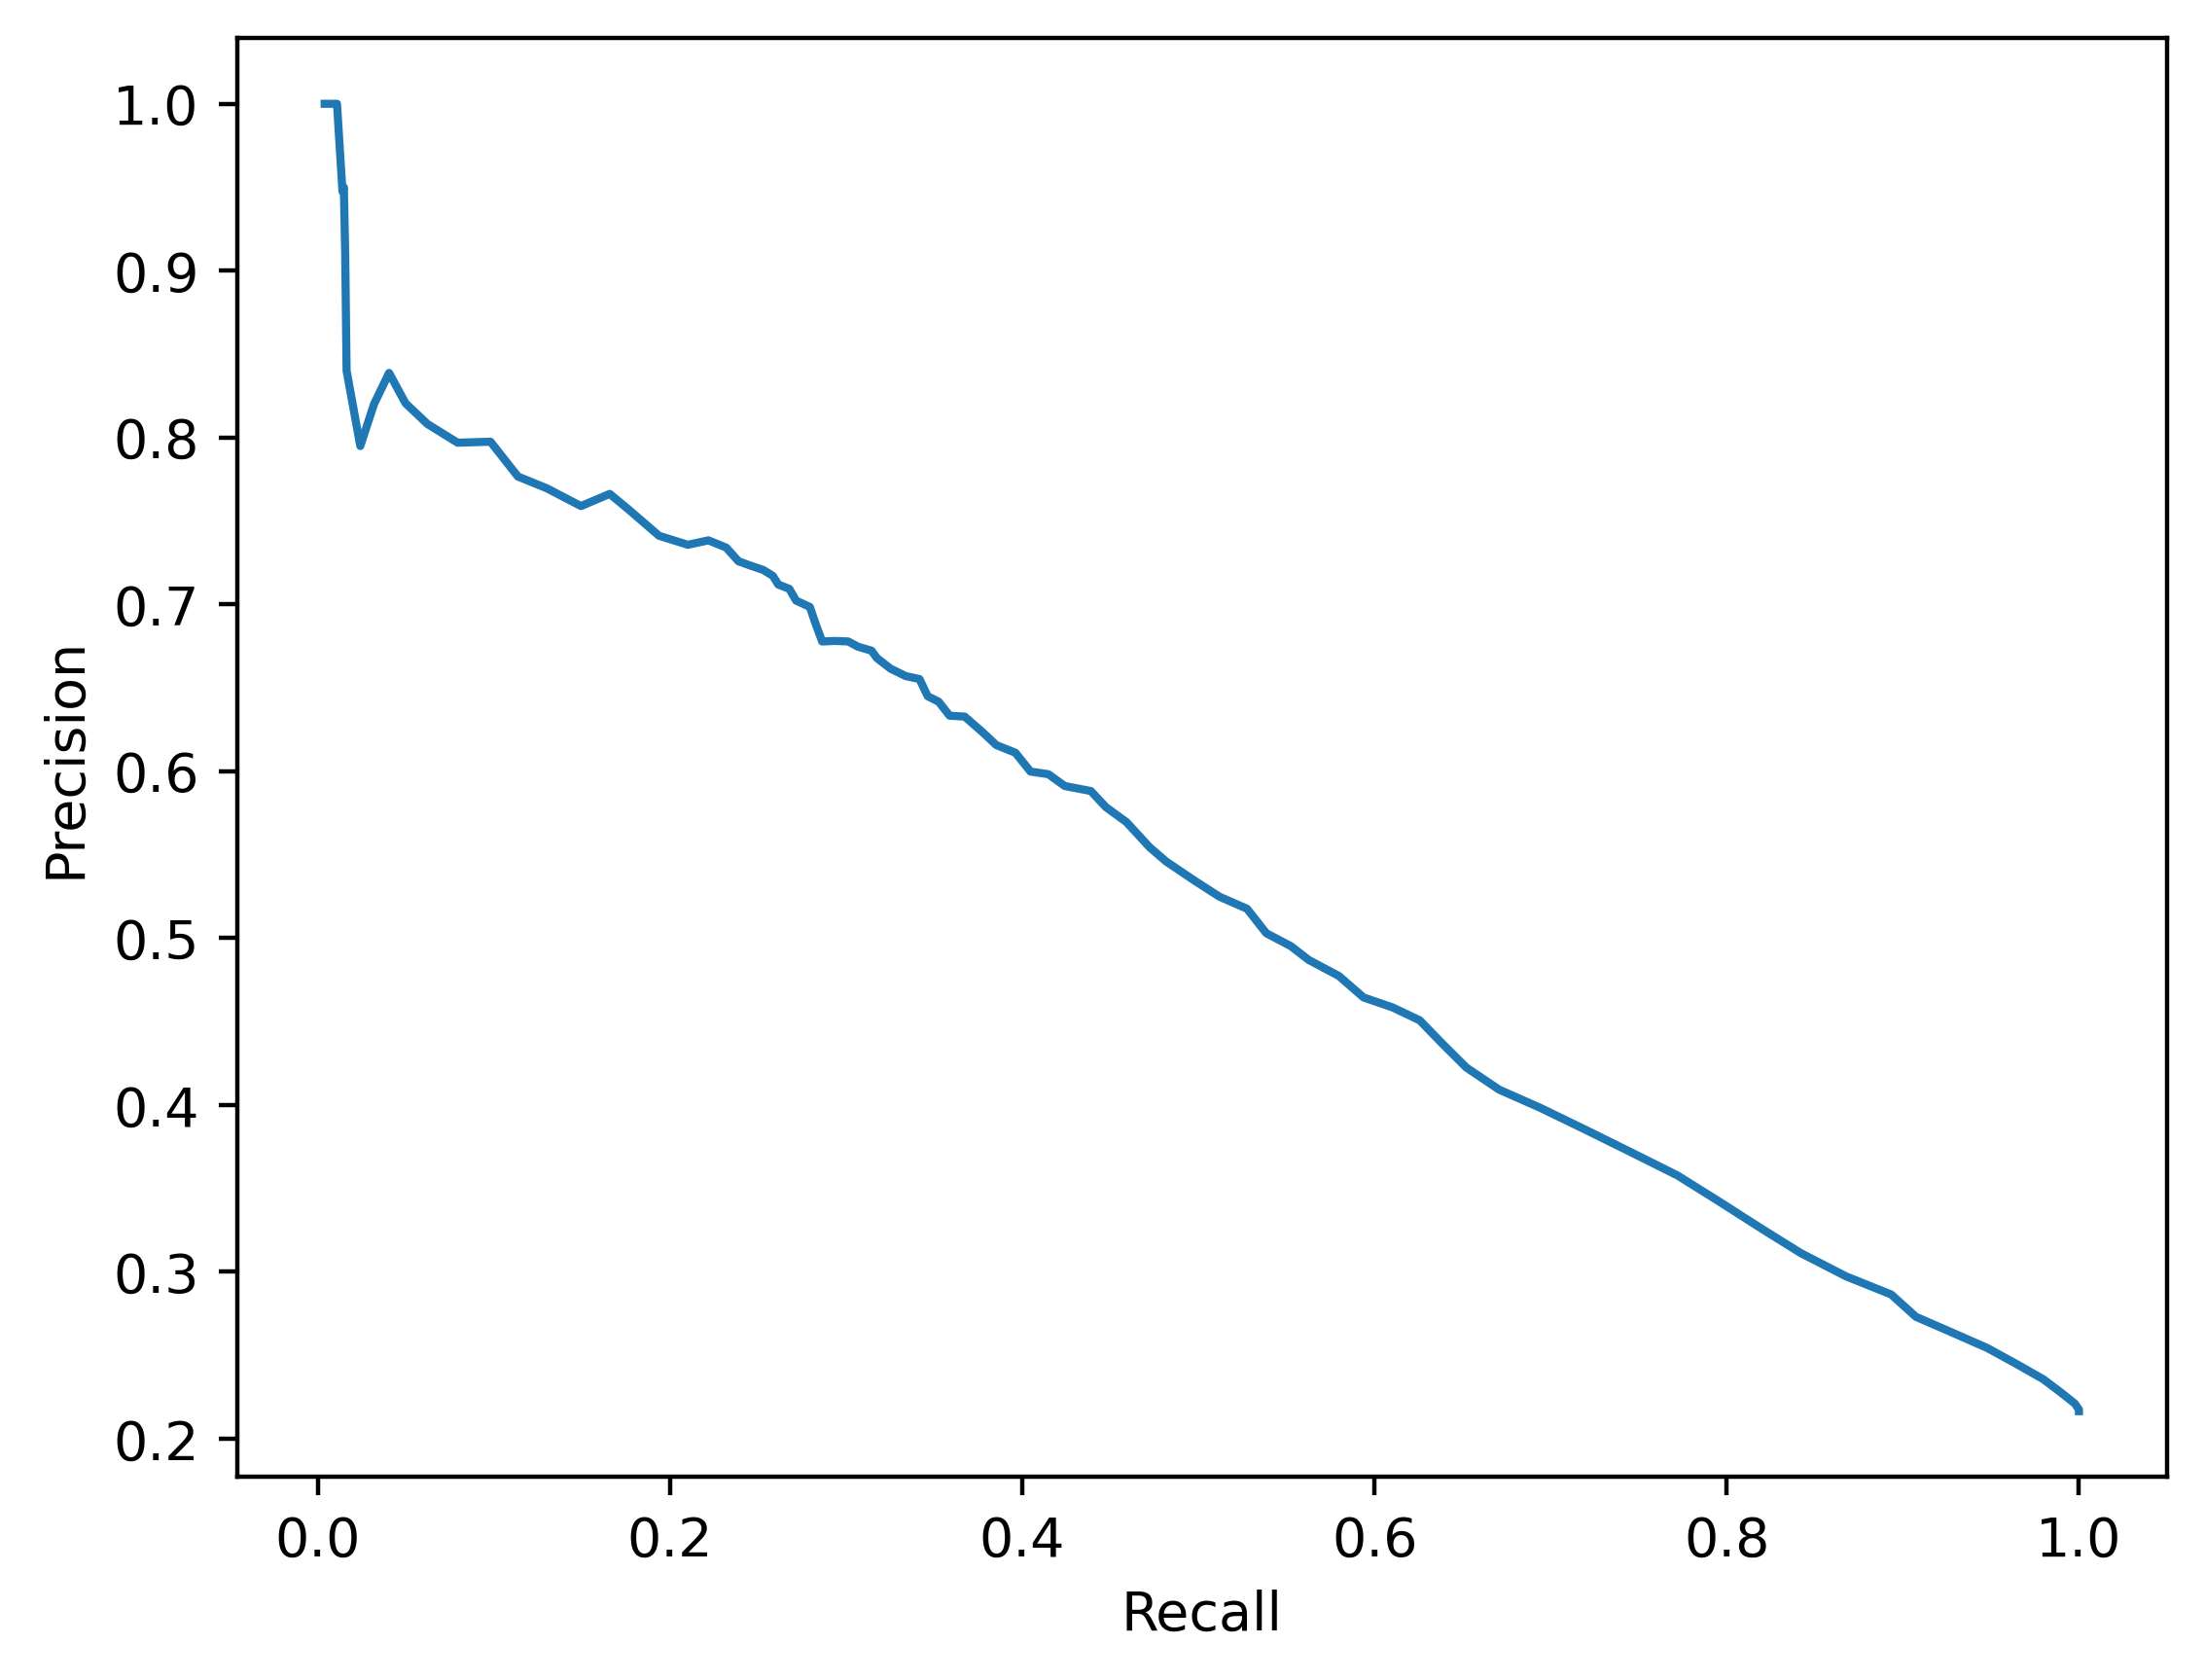

In [100]:
plt.plot(n_true_pos/sum(y_test_all),
         np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision');

/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_55515/3420279237.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred),


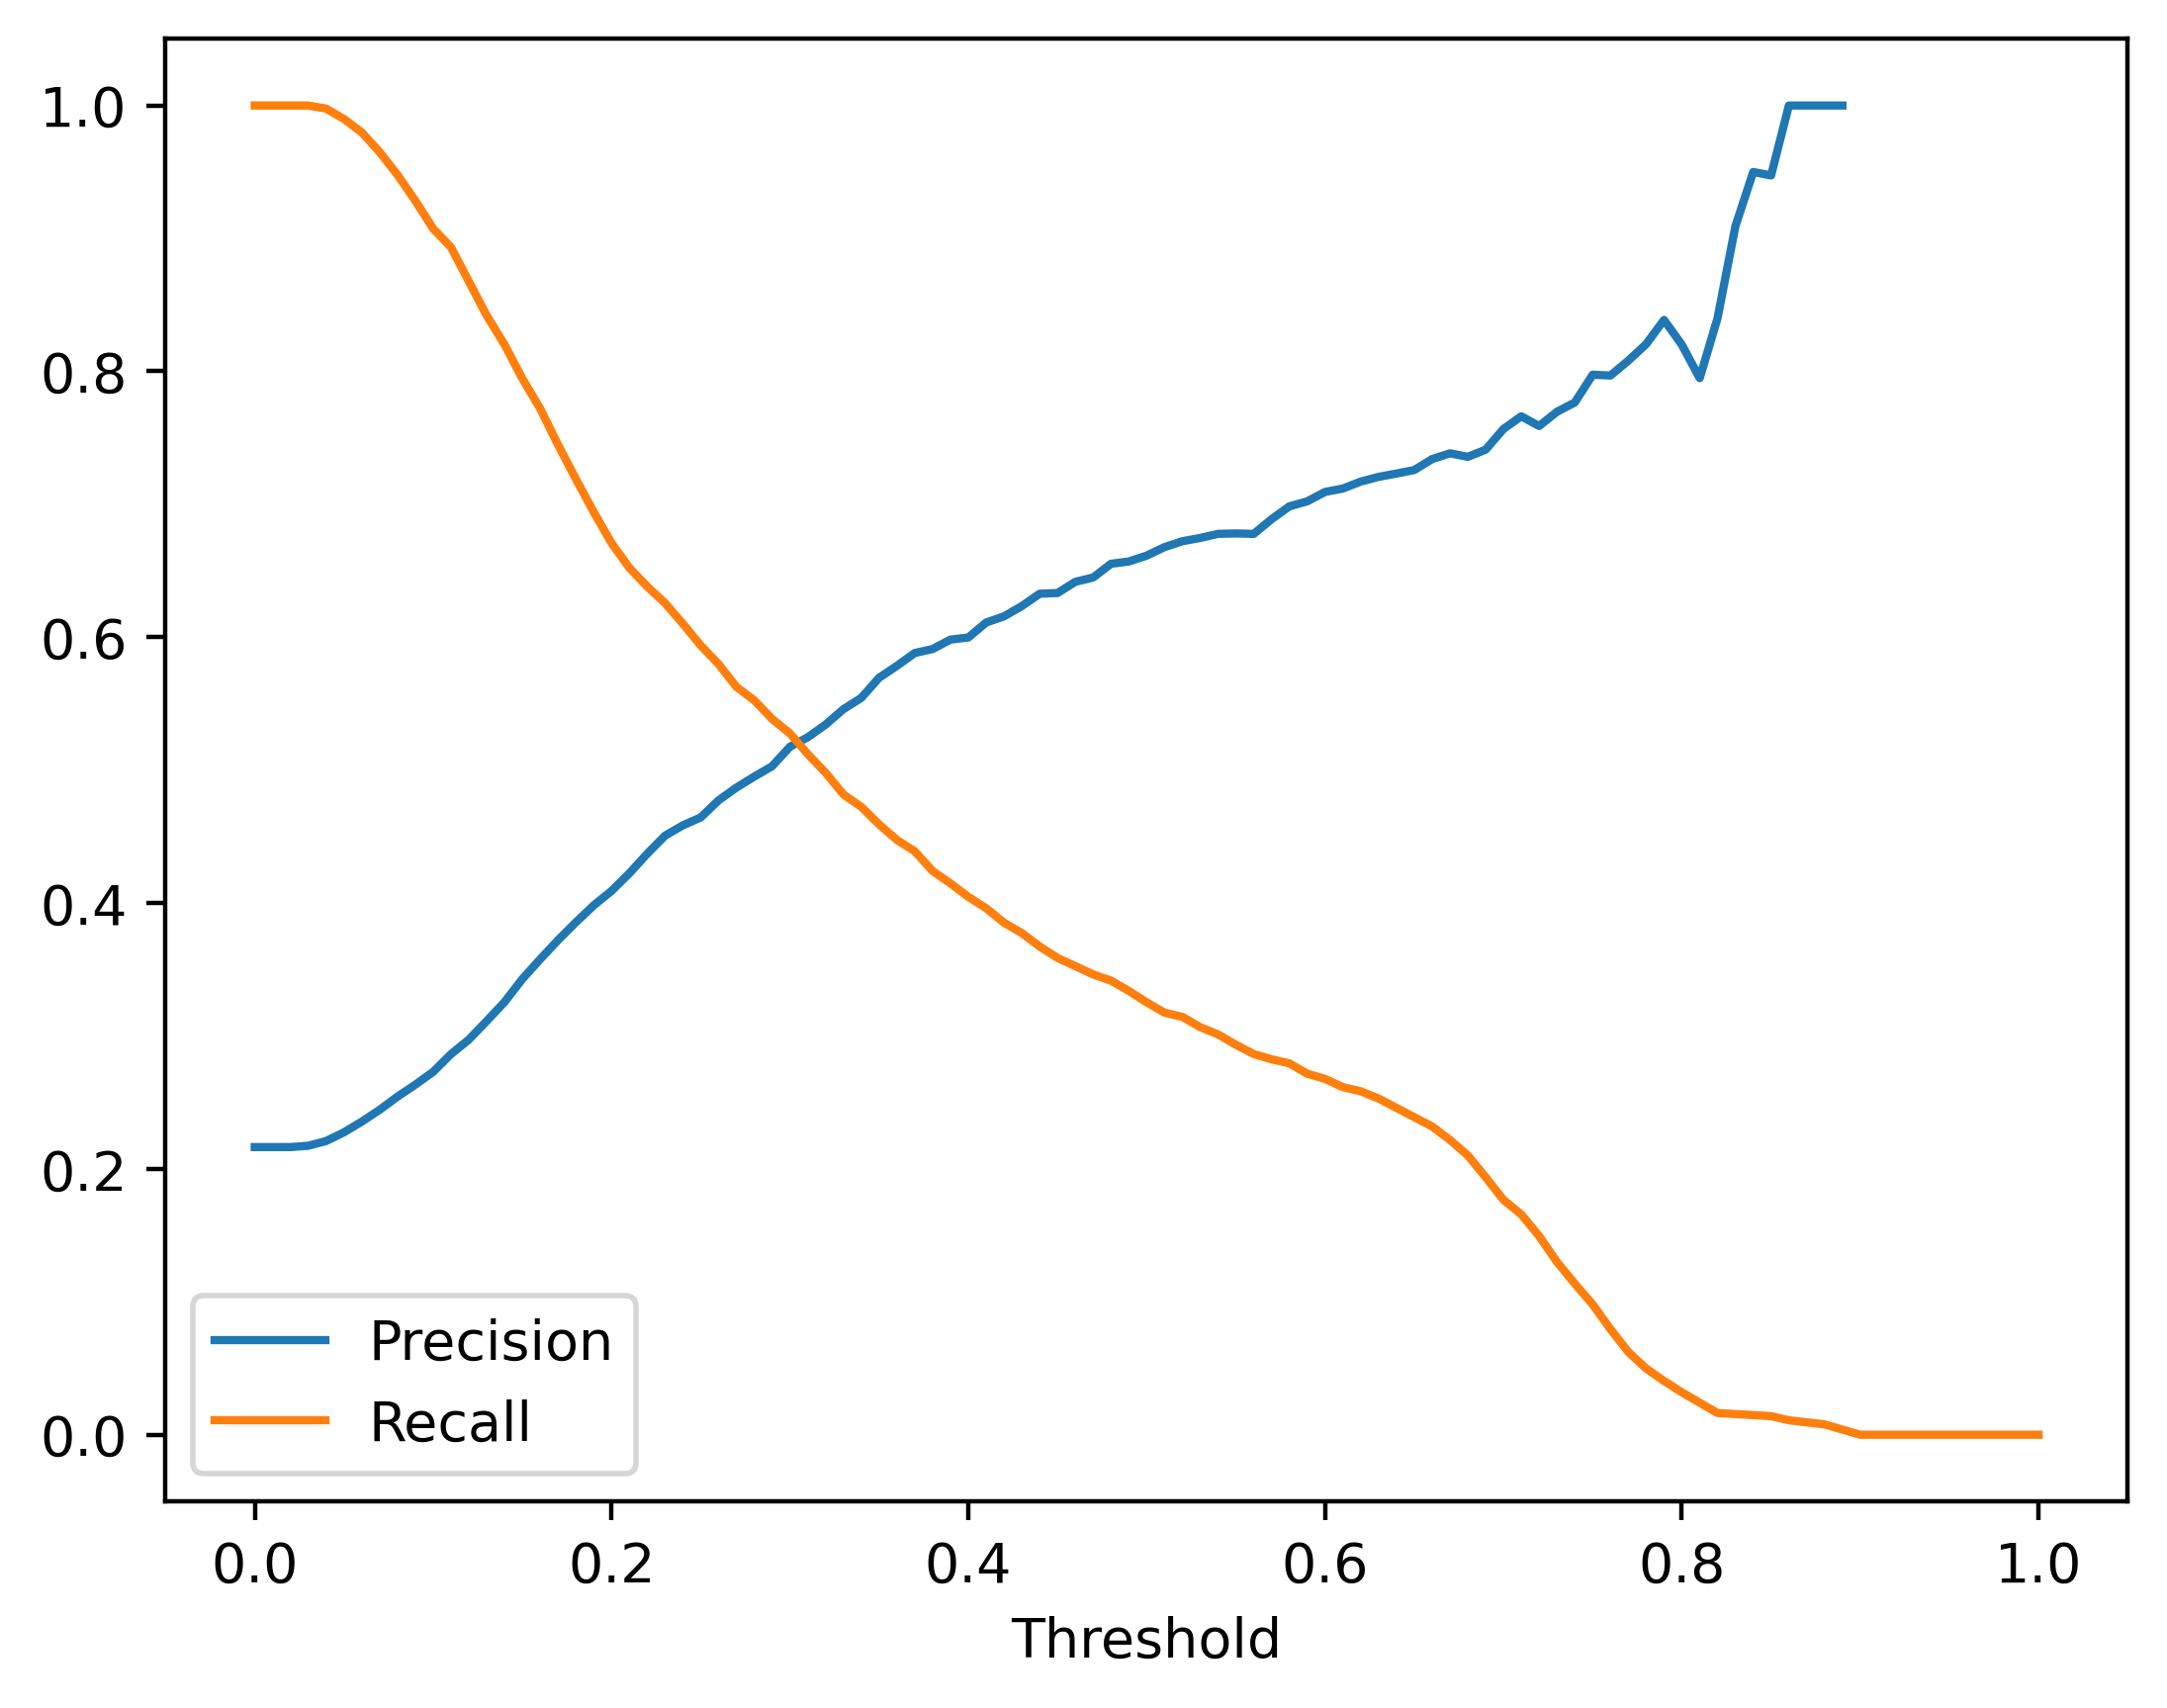

In [102]:
plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred),
         label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test_all),
         label='Recall')
plt.xlabel('Threshold')
plt.legend();

This plot sheds some light on why the optimal threshold was 0.36. While the optimal threshold also depends on the financial analysis of costs and savings, we can see here that the steepest part of the initial increase in precision, which represents the correctness of positive predictions and is, therefore, a measure of how cost-effective the model-guided counselling can be, happens up to a threshold of about 0.36.